## Tests for unsupervised document similarity for ranking in online health communities

In [2]:
from io import open
import json
import random 
from time import time
from collections import Counter

import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

## What does the data look like?

#### train_data.json

* _(list)_ of discussions
    * _(str)_ `category` -- freetext category of a discussion
    * _(str)_ `heading` -- freetext heading of a discussion
    * _(list)_ `posts` -- all of the posts in the discussion
        * _(int)_ `uid` -- id of post in discussion. Zero is original post. Unique within a discussion
        * _(int)_ `parent_uid` -- id of the post that this post is in reply to. Root post has itself as the parent
        * _(str)_ `user` -- freetext user name for the author of the post
        * _(int)_ `timestamp` -- normalized unix timestamp of the post 
        * _(str)_ `text` -- freetext of the post, not tokenized
            
**NOTE:** Some posts are missing any of category, user, or timestamp, these have been given default values

#### test_data.json

* _(list)_ of discussions
    * _(list)_ `posts` -- all of the posts in a discussion
        * _(int)_ `uid` -- id of post, unique within discussion
        * _(str)_ `text` -- freetext of the post
    * _(list)_ `relevance_scores` -- list of triples of (anchor post id, candidate post id, relevance score)

In [3]:
train_data = json.load(open('train_data.json'))
test_data = json.load(open('test_data.json'))

In [4]:
print "Training Data"
a = np.array([len(d['posts']) for d in train_data])
print "{0} discussions, {1} posts total, \n{2:2.2f} avg posts/discussion with {3:2.2f} std deviation".format(
    len(train_data), a.sum(), a.mean(), a.std())

print "\nTest Data"
a = np.array([len(d['posts']) for d in test_data])
print "{0} discussions, {1} posts total, \n{2:2.2f} avg posts/discussion with {3:2.2f} std deviation".format(
    len(train_data), a.sum(), a.mean(), a.std())

Training Data
20404 discussions, 296118 posts total, 
14.51 avg posts/discussion with 45.27 std deviation

Test Data
20404 discussions, 122 posts total, 
40.67 avg posts/discussion with 6.55 std deviation


In [5]:
train_post_texts = [ post['text'] for discussion in train_data for post in discussion['posts'] ]
test_post_texts = [ post['text'] for discussion in test_data for post in discussion['posts'] ]
all_post_texts = train_post_texts + test_post_texts

## Experiments

The experiment template is as follows: Train some pipeline on a bunch of unlabeled data (raw train + test posts), then use similarity metrics to provide a ranking of a set of documents (all posts within a discussion) to a query document (the anchor post). This ranking will be compared to a gold ranking.

The test metric is [nDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain). Discounted cumulative gain is a measure of ranking quality that weighs the top of the ranking list more than lower down the list. Normalized DCG is when you compute DCG score on a gold ranking of documents as the _idealized DCG_ and then divide test DCG by this.

**We measure the nDCG@top-k where k $\in \{5,10,15\}$**

Additionally we want confidence intervals for the nDCG for each method for each k. 

**We get confidence intervals by doing a bootstrap empircal 95% confidence interval**

This is a little tricky, since our data lie in 9 subgroups (3 anchors for each of the 3 discussions).

We calculate bootstrap statistics for the average nDCG across the 9 subgroups as follows:

Call the nDCGs for each subgroup $x_1, ..., x_9$ and the data average nDCG $\bar{x} = \frac{1}{9}\sum\limits_{i=1}^9{x_i}$.  

To get a bootstrap estimate for this, we must resample these data, by resampling the data for each subgroup and calculating the nDCG for each resample (across the 9 groups).  

Call these $x_1^{*(j)}, ...,  x_9^{*(j)} \text{ for } j\in \{1,...,B\}$ and the average nDCG _for a single resample j_, $\bar{x}^{*(j)}$. 

Then we can compute confidence intervals around $\bar{x}$ the usual way by finding the $\alpha=.025$ boundary quantiles $\delta_{\alpha}, \delta_{1-\alpha}$, such that 

$$P(\bar{x}^* - \delta_{1-\alpha} \leq \bar{x} \leq \bar{x}^* - \delta_{\alpha}) = .95$$

In [6]:
from ranking_metrics import ndcg_score

In [21]:
def bootstrap_score(trues, preds, scoring_func, B=10000, **scoring_func_kwds):
    """ Compute a bootstrapped estimate of the model score. 
    
    An intuitive and practical guide to bootstrap estimation:
    https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
    """
    samples = []
    idxs = np.arange(len(trues))
    for i in range(B):
        sample = npr.choice(idxs, len(idxs))
        samples.append(scoring_func(trues[sample], preds[sample], **scoring_func_kwds))
    return samples

def score_model_at_k(model, k, data=test_data, 
                     verbose=0, B=10000,
                     refit_per_discussion=False):
    """ Take some model, get relevance scores from it on test data, return nDCG at specified k"""
    if verbose: print 'k={}'.format(k), '-'*50
    all_scores = []
    for i, discussion in enumerate(data):
        if refit_per_discussion:
            model.fit([post['text'] for post in discussion['posts']])
        scores = {}
        for anchor_id, candidate_id, true_score in discussion['relevance_scores']:
            # organize true relevance scores grouped by anchor post
            if anchor_id in scores:
                scores[anchor_id]['trues'].append(true_score)
            else:
                scores[anchor_id] = {'trues':[true_score], 'preds':[]}
            
            pred_score = model.predict(discussion['posts'][anchor_id]['text'],
                                       discussion['posts'][candidate_id]['text'])
#             print pred_score
            scores[anchor_id]['preds'].append(pred_score)
#             if verbose: print true_score, pred_score
        for anchor_id in scores:
            trues = np.array(scores[anchor_id]['trues'])
            preds = np.array(scores[anchor_id]['preds'])
            ndcg = ndcg_score(trues, preds, k=k)
            ndcg_bootstrapped = bootstrap_score(trues, preds, ndcg_score, B=B, k=k)
            # the true ndcg will just be the first one, all the rest are resampled
            all_scores.append([ndcg] + ndcg_bootstrapped)
            if verbose: print 'Discussion {0} ndcg for anchor {1} = {ndcg:2.2f}'.format(i, anchor_id,
                                                                                        ndcg=ndcg)
    return all_scores
        
def score_model(model, model_name, ks=[5,10,15], B=10000, **kwds):
    """ Run the entire experiment for some pretrained model. """
    results = {}
    fig, axs = plt.subplots(1,len(ks),figsize=(3*len(ks),3))
    for i, k in enumerate(ks):
        # do scoring
        all_scores = score_model_at_k(model, k, B=B, **kwds)
        ndcgs = [ scores[0] for scores in all_scores]
        ndcgs_resampled = zip(*[bootstrap_sample[1:] for bootstrap_sample in all_scores])
        ndcg_mean, resampled_means = np.mean(ndcgs), [np.mean(sample) for sample in ndcgs_resampled]
        diffs = [resampled_mean - ndcg_mean for resampled_mean in resampled_means]
#         variance = 
        alpha = .025
        ci_bottom = ndcg_mean - np.percentile(diffs, 100.*(1-alpha))
        ci_top = ndcg_mean - np.percentile(diffs, 100.*alpha)
        results[k] = {
            'mean':ndcg_mean,
            'ci':(ci_bottom, ci_top)
            'scores':[ score for scores in all_scores for score in scores ]
        }
#         print "nDCG@{k}: mean={mean:2.2f}, std={std:2.2f}".format(k=k, mean=mean, std=std)

        # make nice plots
        flat_ndcgs = [ ndcg for sample in all_scores for ndcg in sample ]
        axs[i].hist(flat_ndcgs, bins=.1*np.arange(11))
        axs[i].axvline(ndcg_mean, color='red')
        axs[i].axvspan(ci_bottom, ci_top, alpha=.25, color='red')
        axs[i].set_xlim((-.05, 1.05))
        axs[i].set_title("nDCG@{k} Histogram".format(k=k))
        axs[i].set_xlabel("nDCG: mean={mean:2.2f}, \n95% CI = ({ci_bottom:2.2f}, {ci_top:2.2f})".format(
                mean=ndcg_mean, ci_bottom=ci_bottom, ci_top=ci_top))
        if i == 0:
            axs[i].set_ylabel("Bin Count")
    fig.suptitle("Bootstrapped nDCG for {} (B={})".format(model_name, B), fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    results['fig'] = fig
    return results

SyntaxError: invalid syntax (<ipython-input-21-047b948e1168>, line 65)

In [8]:
results = {}

## Models

### Baselines

1. Random similarity scores
2. TF-IDF
3. LSA on token-doc matrix (How do topic models deal with short docs?)
4. LDA on union of train and test docs. Score is inner product of topic vectors
5. SF-IDF ([paper](https://link.springer.com/chapter/10.1007/978-3-319-07692-8_35))

### Our Models

#### Neural Continuous Bag of Words (CBOW):

We compute document vectors by aggregating dense vector representations of each word, where each vector for a word represents its meaning. This is essentially what SF-IDF was trying to do, but we do it without any reliance on lexicons, knowledge bases, or semantic supervision. Instead use the [GloVe](https://nlp.stanford.edu/projects/glove/) pretrained 300 dimensional vectors from the common crawl.  These vectors model word meaning well and have been trained on the entire internet (42 billion tokens)

** Aggregation Functions:**
1. Mean of all word vectors (omitting stop words) in the document
2. Sum of all word vectors (omitting stop words) in the document
3. TF-IDF weighted sum of all word vectors (omitting stop words) in the document

#### Possible Way Cooler Models
    
There are a few fancy things we could do:
* Document modeling using a variational autoencoder (like NVDM)
* Improve it by using tunable pretrained word embeddings and typing embedding params for discriminator and generator
* Do Neural Gaussian LDA, where the word embeddings are generated from mixture of topic gaussians
* Introduce a third level of grouping that does a discussion-specific prior on the topics

** Neural Variational Gaussian Document Model **

We can do document modeling using a generative model that allows the incorporation of apriori known word similarities through the use of fixed word vectors.

Our generative process is _very_ simple:

1. Sample a latent document representation $z_d \sim \mathcal{N}(\mu, \Sigma^{-1})$
2. For each word $w_i$ in the document with $D$ words:
    1. Sample the word vector $v_{w_i} \sim \mathcal{N}(\mu_{\theta}(z), \Sigma_{\theta}^{-1}(z))$
    


In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation as LDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
stop_vocab = set(stopwords.words('english'))
from nltk.wsd import lesk

In [10]:
class ModelBase(object):
    def fit(self, training_docs_list, **kwds):
        start = time()
        self.pipeline.fit(training_docs_list, **kwds)
        return time() - start
    
    def predict(self, doc1, doc2):
        vecs = self.pipeline.transform([doc1, doc2])
        sim = cosine_similarity(vecs)
        return sim[0,1]
    
def sec2hms(sec):
    """ Convert seconds to hours:minutes:seconds string """
    m, s = divmod(sec, 60)
    h, m = divmod(m, 60)
    return "{0:02d}:{1:02d}:{2:02d}".format(int(h),int(m),int(s))


### Baseline 1: Random similarity scores

In [22]:
class RandomModel(object):
    def predict(self, doc1, doc2):
        return random.random()

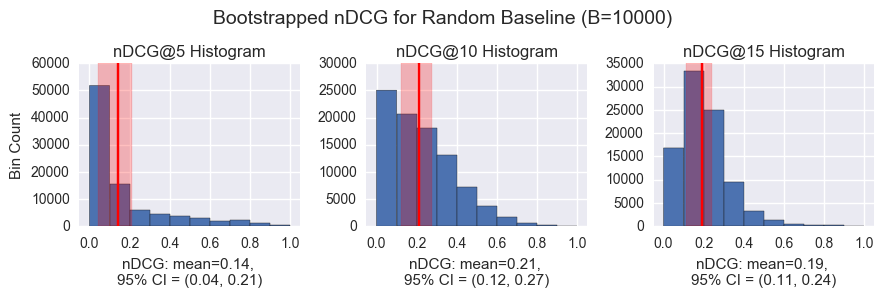

In [23]:
random_model = RandomModel()
model_name = "Random Baseline"
results[model_name] = score_model(random_model, model_name, B=10000, verbose=0)

### Baseline 2: TF-IDF Cosine

In [24]:
class TfIdfModel(ModelBase):
    def __init__(self):
        self.tokenizer = TweetTokenizer()
        self.tokenize = self.tokenizer.tokenize
        self.pipeline = TfidfVectorizer(min_df=5, stop_words='english', tokenizer=self.tokenize)

Training... Took 00:01:44 hours for 296240 docs


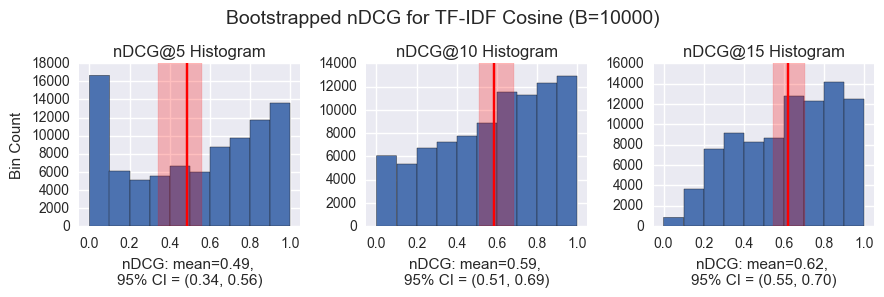

In [25]:
tfidf_model = TfIdfModel()
print "Training...",
train_time = tfidf_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "TF-IDF Cosine"
results[model_name] = score_model(tfidf_model, model_name, B=10000, verbose=0)

Training... Took 00:01:50 hours for 296240 docs


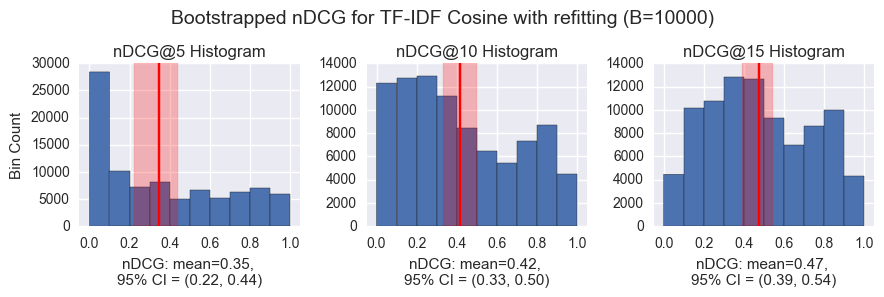

In [26]:
tfidf_model = TfIdfModel()
print "Training...",
train_time = tfidf_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "TF-IDF Cosine with refitting"
results[model_name] = score_model(tfidf_model, model_name, B=10000, verbose=0, refit_per_discussion=True)

### Baseline 3: LSA

In [ ]:
class LSAModel(ModelBase):
    def __init__(self, n_latent):
        self.tokenizer = TweetTokenizer()
        self.tokenize = self.tokenizer.tokenize
        self.vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=self.tokenize)
        self.lsa = TruncatedSVD(n_latent, random_state=0)
        self.pipeline = Pipeline([('vec', self.vectorizer), ('lsa', self.lsa)])

In [ ]:
for d in [10,50,100]:
    lsa_model = LSAModel(d)
    print "Training...",
    train_time = lsa_model.fit(all_post_texts)
    print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
    model_name = "LSA Cosine (latent dim={})".format(d)
    results[model_name] = score_model(lsa_model, model_name, B=10000, verbose=0)

Training...

### Baseline 4: LDA

**Note:** these results aren't correct because LDA hasn't been fit on the whole corpus yet... it's extremely slow...

In [1]:
class LDAModel(ModelBase):
    def __init__(self, n_topics, **lda_kwds):
        self.tokenizer = TweetTokenizer()
        self.tokenize = self.tokenizer.tokenize
        self.vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=self.tokenize)
        self.lda = LDA(n_topics, learning_method='online',
                       random_state=0, **lda_kwds)
        self.pipeline = Pipeline([('vec', self.vectorizer), ('lda', self.lda)])

NameError: name 'ModelBase' is not defined

 Training... Took 00:00:01 hours for 296240 docs
Training... Took 00:00:01 hours for 296240 docs
Training... Took 00:00:01 hours for 296240 docs


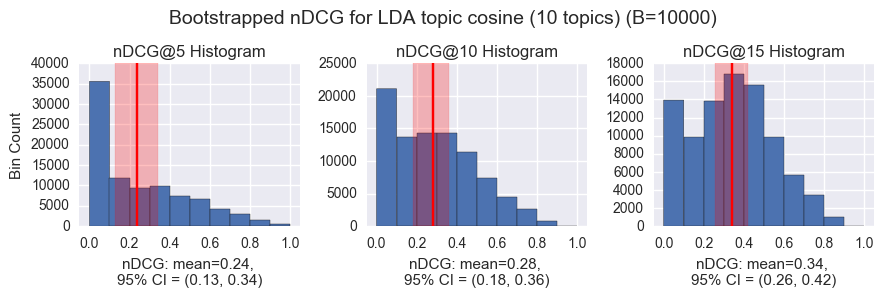

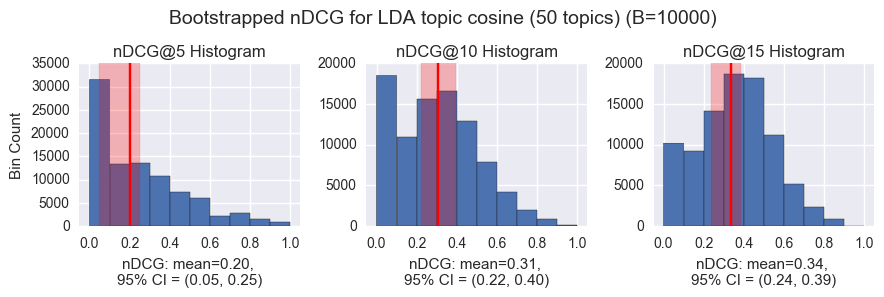

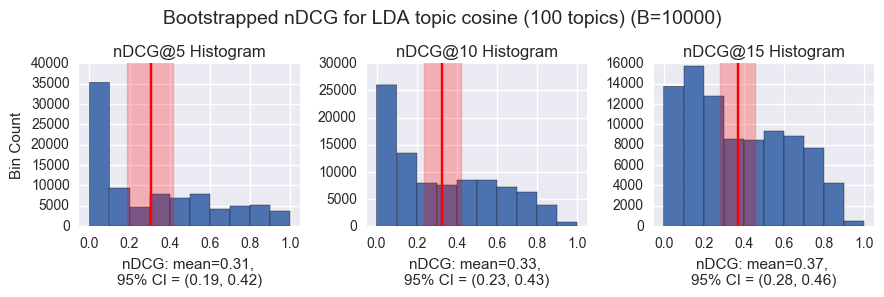

In [52]:
for d in [10,50,100]:
    lda_model = LDAModel(d, n_jobs=-1)
    print "Training...",
    train_time = lda_model.fit(all_post_texts[:100])
    print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
    model_name = "LDA topic cosine ({} topics)".format(d)
    results[model_name] = score_model(lda_model, model_name, B=10000, verbose=0)

### Baseline 5: SF-IDF

In [ ]:
class SfIdfModel(ModelBase):
    def __init__(self, window_width=10):
        self.tokenizer = TweetTokenizer()
        
        def sf_transform(doc_string):
            """ Tokenize the input with NLTK, do word sense disambiguation, then do synset transformation. """
            tokens = self.tokenizer.tokenize(doc_string)
            for i, token in enumerate(tokens):
                start = 0 if i-window_width < 0 else i-window_width
                synset = lesk(tokens[s:i+window_width], token)
                if synset:
                    tokens[i] = synset.name()
            return tokens
    
        self.pipeline = TfidfVectorizer(min_df=5, stop_words='english', tokenizer=sf_transform)

In [ ]:
sfidf_model = SfIdfModel()
print "Training...",
train_time = sfidf_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "SF-IDF Cosine"
results[model_name] = score_model(sfidf_model, model_name, B=10000, verbose=0)

### Baseline 6: Neural Continuous Bag of Words (average of word vectors)

In [16]:
class NeuralCBOWModel(object):
    def __init__(self, composition_func=np.mean):
        self.word2vec = {}
        self.tokenizer = TweetTokenizer()
        self.composition_func = composition_func
        
    def fit(self, training_docs_list):
        start = time()
        token_set = { token for doc in training_docs_list 
                      for token in self.tokenizer.tokenize(doc)
                      if token not in stop_vocab}
        for i, line in enumerate(open('glove.840B.300d.txt')):
            split = line.strip().split()
            try:
                word, vec = split[0], np.array(split[1:], dtype=np.float32)
            except: 
                continue
            if word not in token_set:
                continue
            vec /= np.linalg.norm(vec)
            self.word2vec[word] = vec
            if len(self.word2vec) >= len(token_set): break
        # every token in the dataset has a vector
        # print "{}/{} tokens have pretrained vectors".format(len(self.word2vec), len(token_set))
        return time() - start
    
    def doc2vec(self, doc_str):
        tokens = self.tokenizer.tokenize(doc_str)
        doc_matrix = np.vstack([self.word2vec[token] for token in tokens if token in self.word2vec])
        return self.composition_func(doc_matrix, axis=0)
    
    def predict(self, doc1, doc2):
        vec1, vec2 = self.doc2vec(doc1), self.doc2vec(doc2)
        return np.dot(vec1, vec2)

Training... Took 00:06:07 hours for 296240 docs


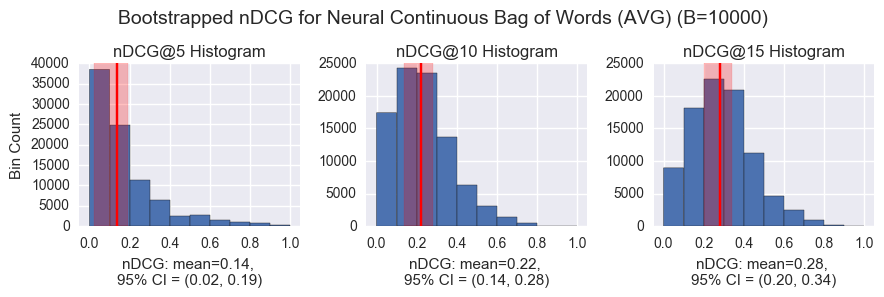

In [17]:
ncbow_model = NeuralCBOWModel()
print "Training...",
train_time = ncbow_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "Neural Continuous Bag of Words (AVG)"
results[model_name] = score_model(ncbow_model, model_name, B=10000, verbose=0)

Training... Took 00:06:06 hours for 296240 docs


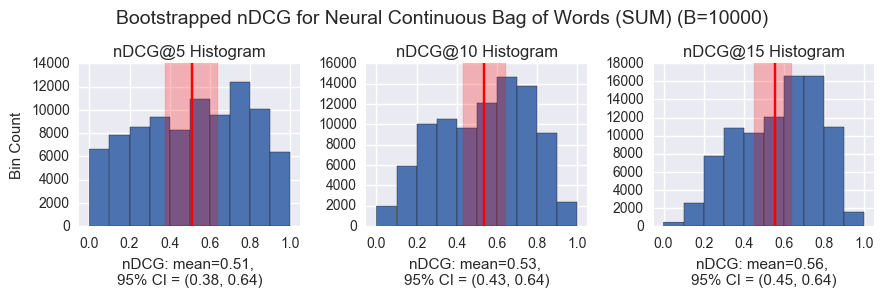

In [18]:
ncbow_model = NeuralCBOWModel(composition_func=np.sum)
print "Training...",
train_time = ncbow_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "Neural Continuous Bag of Words (SUM)"
results[model_name] = score_model(ncbow_model, model_name, B=10000, verbose=0)

In [19]:
class TfIdfNeuralCBOWModel(object):
    def __init__(self):
        self.word2vec = {}
        self.tokenizer = TweetTokenizer()
        self.tokenize = self.tokenizer.tokenize
        self.tfidf = TfidfVectorizer(min_df=5, stop_words='english', tokenizer=self.tokenize)
        
    def fit(self, training_docs_list):
        start = time()
        self.tfidf.fit(training_docs_list)
        token_set = { token for doc in training_docs_list 
                      for token in self.tokenize(doc)
                      if token not in stop_vocab }
        for i, line in enumerate(open('glove.840B.300d.txt')):
            split = line.strip().split()
            try:
                word, vec = split[0], np.array(split[1:], dtype=np.float32)
            except: 
                continue
            if word not in token_set:
                continue
            vec /= np.linalg.norm(vec)
            self.word2vec[word] = vec
            if len(self.word2vec) >= len(token_set): break
        self.vocab_set = set(self.word2vec.keys()) & set(self.tfidf.vocabulary_.keys())
        # every token in the dataset has a vector
        # print "{}/{} tokens have pretrained vectors".format(len(self.word2vec), len(token_set))
        return time() - start
    
    def doc2vec(self, doc_str):
        tfidf_vec = self.tfidf.transform([doc_str])
        tokens = [ token for token in self.tokenize(doc_str) if token in self.vocab_set ]
        doc_matrix = np.vstack([self.word2vec[token] for token in tokens])
        matching_weights = np.array([ tfidf_vec[0, self.tfidf.vocabulary_[token]] for token in tokens])
        weighted_doc_vec = (doc_matrix.T * matching_weights).sum(axis=1)
        return weighted_doc_vec
    
    def predict(self, doc1, doc2):
        vec1, vec2 = self.doc2vec(doc1), self.doc2vec(doc2)
        return np.dot(vec1, vec2)

Training... Took 00:07:41 hours for 296240 docs


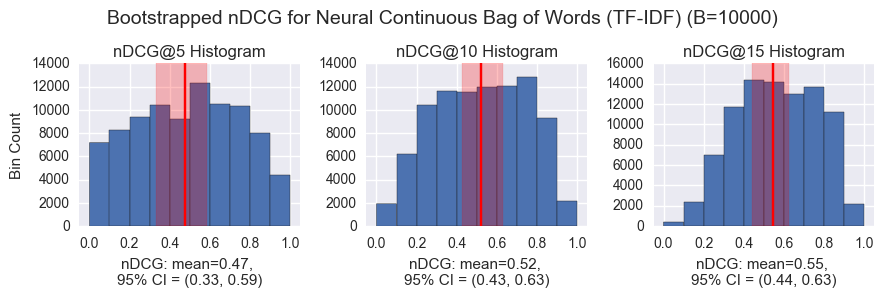

In [20]:
tfidf_ncbow_model = TfIdfNeuralCBOWModel()
print "Training...",
train_time = tfidf_ncbow_model.fit(all_post_texts)
print "Took {} hours for {} docs".format(sec2hms(train_time), len(all_post_texts))
model_name = "Neural Continuous Bag of Words (TF-IDF)"
results[model_name] = score_model(tfidf_ncbow_model, model_name, B=10000, verbose=0)

### Output the results as a table